<a href="https://colab.research.google.com/github/bathicodes/EXPERIMENTS/blob/main/Dogs_vs_Cats_PyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

## Import libraries and setting up environment

In [48]:
import torch
from torch import nn
from google.colab import drive

# print torch
print(torch.__version__)

2.0.0+cu118


In [49]:
# check gpu
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [50]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Going thorugh data (data preparation and data exploration)

In [51]:
from pathlib import Path

drive.mount("/content/drive")

cloud_path = "/content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset"
path = Path(cloud_path)

# setup training and testing path
train_dir = path / "training_set"
test_dir = path / "test_set"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os

def walk_through(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(dirnames)} images in {dir_path}")

In [53]:
walk_through(path)

There are 3 directories and 3 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 2 directories and 2 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 2 directories and 2 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset
There are 0 directories and 0 images in /content/drive/MyDrive/Machine Learning/ML Reboot/CNN with dataset/dataset


## Visualizing images

(-0.5, 499.5, 460.5, -0.5)

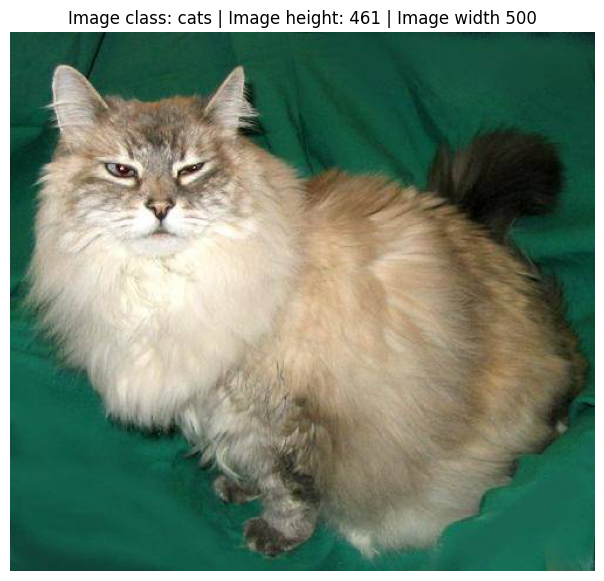

In [54]:
import random
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt

# set random seed
random.seed(42)

# 1. get all the image paths
image_path_list = list(path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get image class name from path
image_class = random_image_path.parent.stem

# 4. open image
image = Image.open(random_image_path)

# 5. convert image into array
image_to_array = np.asarray(image)

# 6. plot with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_to_array)
plt.title(f"Image class: {image_class} | Image height: {image.height} | Image width {image.width}")
plt.axis(False)

## Transforming data

In [55]:
from torchvision import datasets, transforms

train_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

## Loading image data using ImageFolder

In [56]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_data_transforms)

In [57]:
class_names = train_data.classes
class_names

['cats', 'dogs']

In [58]:
train_data.class_to_idx

{'cats': 0, 'dogs': 1}

## Turn datasets into DataLaoders

In [59]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data,
                              batch_size=NUM_WORKERS,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Model

## Create model

In [60]:
class TinyVGG(nn.Module):
  """
  Model architecture copying from TinyVGG from CNN explainer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

## Try a forward pass on a single image (to test the model)

In [62]:
# get single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2]))

In [63]:
# try a forward pass
model_0(image_batch.to(device))

tensor([[0.0059, 0.0096],
        [0.0120, 0.0074]], grad_fn=<AddmmBackward0>)

## Use torchinfo to get model summary

In [65]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create train and test loops

In [66]:
# create training loop
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  
  # put the model in train mode
  model.train()

  # setup train loss and accuracy loss
  train_loss, train_acc = 0, 0

  # loop thorugh the dataloader's data batches
  for batch, (X,y) in enumerate(dataloader):
    
    # send data to the target device
    X,y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. calcukate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [67]:
# create test loop
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module,
              device=device):
  
  # put model on evaluation model
  model.eval()
  
  # setup test loss and test accuracy
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():
    
    # loop thorugh the dataloader's data batches
    for batch, (X,y) in enumerate(dataloader):

      # send data to the target device
      X,y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred_logits = model(X)

      # 2. calculate the loss
      test_loss = loss_fn(test_pred_logits, y)
      test_loss += test_loss.item()

      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [68]:
from tqdm.auto import tqdm

# 1. create a train function that takes in various model parameters + optimizer + loss + model
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  
  # 2. create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. print status
    print(f"Epochs: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. update results dictonary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. return the filled results at the end ot the epochs
  return results

In [70]:
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs 
EPOCHS = 5

# recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                          lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

# end the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 0.6911 | Train acc: 0.5277 | Test loss 0.0210 | Test acc: 0.5521
Epochs: 1 | Train loss: 0.6873 | Train acc: 0.5481 | Test loss 0.0214 | Test acc: 0.5655
Epochs: 2 | Train loss: 0.6858 | Train acc: 0.5485 | Test loss 0.0211 | Test acc: 0.5486
Epochs: 3 | Train loss: 0.6852 | Train acc: 0.5505 | Test loss 0.0211 | Test acc: 0.5526
Epochs: 4 | Train loss: 0.6847 | Train acc: 0.5552 | Test loss 0.0197 | Test acc: 0.5511
Total training time: 3007.350 seconds


In [71]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""

  # get the loss values from the results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuracy values from the results dictionary
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out the epochs count
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15,7))

  # plot loss curves
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs") 
  plt.legend()

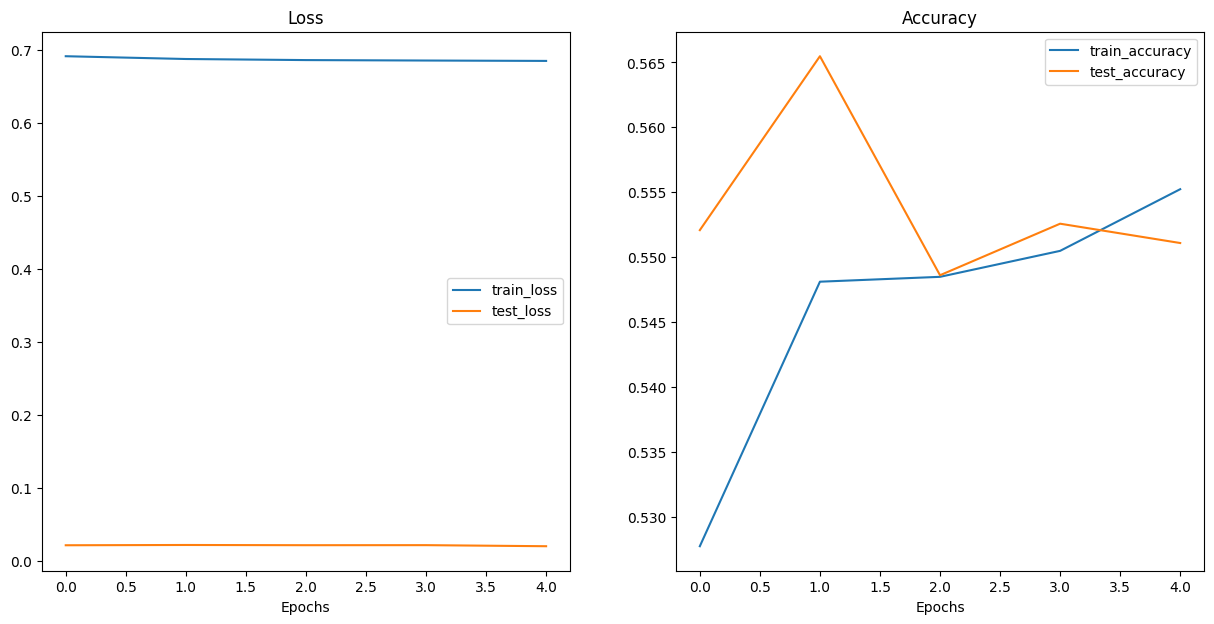

In [72]:
plot_loss_curves(model_0_results)